In [1]:
import calendar
import datetime as dt
from itertools import chain
from datetime import datetime, timedelta
from IPython.core import display as ICD
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [2]:
####################################################
#xls_files = glob.glob('FitbitData/*.xls')
#activities = [pd.ExcelFile(xls).parse('Activities', index_col=0, parse_dates=True) for xls in xls_files]
#sleep = [pd.ExcelFile(xls).parse('Sleep', usecols=':F') for xls in xls_files]
#sleep = [pd.ExcelFile(xls).parse('Sleep', usecols=':F', index_col=[0,1], parse_dates=True) for xls in xls_files]
#sleep = [pd.ExcelFile(xls).parse('Sleep', usecols=':F', index_col=0, parse_dates=True) for xls in xls_files]
####################################################

# -- STORE ALL FITBIT DATA INTO LISTS OF SHEET --
xls_files = glob.glob('Fitbit/*.xls')

## Functions

In [3]:
def add_weekday(df, not_index=0):
    """Add day of week column"""
    
    # -- USE DATAFRAME'S INDEX IF 'not_index' = 1, OTHERWISE USE DATAFRAME'S 'Date' COLUMN --
    col = df.index
    if not_index:
        col = df['Date']
    
    # -- DETERMINE THE DAY OF WEEK FROM THE DATE AND STORE IN A LIST (USED TO ADD AS A COLUMN TO THE DATAFRAME) --
    weekday = []
    for date in col:
        #weekday.append(datetime.strptime(str(date), '%Y-%m-%d').strftime('%A'))
        weekday.append(calendar.day_name[date.weekday()])
    df.loc[:, 'Weekday'] = weekday
    
    
def to_num(df, list_of_cols):
    """Remove commas and convert values to a numeric data type"""
    
    for col in list_of_cols:
        #df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('\D', '', regex=True)
        df[col] = pd.to_numeric(df[col])
        

def to_date(df, list_of_col):
    """Convert columns into datetime type"""
    
    for col in list_of_col:
        df[col] = pd.to_datetime(df[col])

### Function for wrangling sleep data

In [4]:
def sort_sleep_data(list_of_df):
    """Sort sleep data by date"""
    
    for i in range(len(list_of_df)):
        list_of_df[i].sort_values(by='Start Time', ascending=True, inplace=True)

### Functions for wrangling food and macros data

In [5]:
def flatten_list(l):
    """Flatten a list"""
    
    return list(chain(*l))


def get_sheetnames_and_dates(excel_file):
    """Only get sheet names and dates for days where food data is entered"""
    """Returns: 2 lists (sheet names & dates)"""
    
    monthly_calories = pd.ExcelFile(excel_file).parse('Foods')

    dates = []
    sheet_names = []
    
    # -- GET SHEET NAMES AND DATES ONLY FOR THE DAYS WHERE INFO ABOUT FOOD INTAKE IS ENTERED --
        # -- daily[0]: date --
        # -- daily[1]: calories --
    for daily in monthly_calories.values:
        if str(daily[1]) != '0':
            dates.append(datetime.strptime(daily[0], '%Y-%m-%d').date())
            foodLogSheetName = 'Food Log ' + daily[0].replace('-', '')
            sheet_names.append(foodLogSheetName)
    return sheet_names, dates


def remove_empty_rows(xls, sheet_list):
    """Converting data in labeled table format to dataframe format"""
    """Returns: dataframe without unnecessary data"""
    
    df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_list]

    # -- REMOVING UNNECESSARY ROWS & FILLING IN 'MISSING' DATA --
    for df in df_list:
        df.dropna(how='all', inplace=True)
        df['Meal'] = df['Meal'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        
    return df_list


def get_food_and_macros(food_list, dates_list):
    """Get macros information into desirable dataset format"""
    """Returns: 2 dataframes (one with food consumption data & one with daily macros info)"""

    macros_df = pd.DataFrame()
    all_food_df = pd.DataFrame()
    all_macros_df = pd.DataFrame()
    
    # -- SPLITTING DATA INTO TWO DIFFERENT DATAFRAMES --
    for ind, (df, date) in enumerate(zip(food_list, dates_list)):
        
        index_of_macros = []

        # -- STORE INDEX OF ROWS THAT HAVE MACROS DATA --
        for i in df.index:
            if df['Meal'][i] == 'Daily Totals':
                index_of_macros.append(i)

        # -- EXTRACT MACROS DATA FROM THE DATAFRAME. CREATE & STORE MACROS DATA IN A NEW DATAFRAME --
        macros_df = df.iloc[index_of_macros[1]:index_of_macros[-1]+1]
        macros_df['Date'] = date
        macros_df = macros_df.pivot(index='Date', columns='Food', values='Calories')
        all_macros_df = all_macros_df.append(macros_df)
        
        #food_list[ind].drop(index=index_of_macros)
        #food_list[ind].dropna(inplace=True)
        #food_list[ind].reset_index(drop=True, inplace=True)

        # -- ADD 'Date' COLUMN TO THE FOOD DATAFRAME --
        food_list[ind]['Date'] = date

        # -- STORE EACH UPDATED FOOD DATAFRAME INTO A NEW DATAFRAME --
        all_food_df = all_food_df.append(food_list[ind].drop(index=index_of_macros).dropna())

    return all_food_df, all_macros_df

## Data wrangling

### Cleaning activities & sleep data

In [6]:
# -- STORING DATA IN EXCEL AS LISTS DATAFRAMES --
list_of_activities_df = [pd.ExcelFile(xls).parse('Activities', index_col=0, parse_dates=True) for xls in xls_files]
list_of_sleep_df = [pd.ExcelFile(xls).parse('Sleep', usecols=':F') for xls in xls_files]

# -- CONCATING ALL FOOD DATAFRAMES INTO ONE BIG DATAFRAME --
activities = pd.concat(list_of_activities_df)
add_weekday(activities)

# -- CONCATING ALL SLEEP DATAFRAMES INTO ONE BIG DATAFRAME --
sort_sleep_data(list_of_sleep_df)
sleep = pd.concat(list_of_sleep_df)
sleep.reset_index(drop=True, inplace=True)

### Cleaning food data

In [7]:
# -- GET ALL NECESSARY SHEET NAMES AND DATES --
sheet_names, dates = zip(*[get_sheetnames_and_dates(xls) for xls in xls_files])
dates = [d for d in dates if d]

# -- FIRST STEP IN DATA CLEANING: REMOVING ALL EMPTY ROWS --
list_of_food_df = [remove_empty_rows(xls, monthly_sheets) for xls, monthly_sheets in zip(xls_files, sheet_names) if monthly_sheets]

# -- SECOND STEP IN DATA CLEANING: SPLIT ORIGINAL DATAFRAMES INTO SEPARATE DATAFRAMES --
list_of_food_df, list_of_macros_df = zip(*[get_food_and_macros(monthly_food, date) for monthly_food, date in zip(list_of_food_df, dates)])

macros = pd.concat(list_of_macros_df)
food = pd.concat(list_of_food_df)
food.reset_index(drop=True, inplace=True)

add_weekday(macros)
add_weekday(food, 1)

/Users/vwu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Activities data
---

In [8]:
sns.set()

In [9]:
to_num(activities, ['Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories'])
activities = activities[activities['Steps'] != 0]
activities

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Weekday
Date,,,,,,,,,,
2015-10-21,2150,14061,5.71,17,1440.0,0,0,0,0,Wednesday
2015-10-22,2274,13617,5.46,12,596.0,300,17,69,1344,Thursday
2015-10-23,2174,16530,6.57,20,639.0,361,15,35,1275,Friday
2015-10-24,2161,14710,5.88,11,550.0,278,36,52,1227,Saturday
2015-10-25,1515,5077,2.02,8,869.0,112,9,14,401,Sunday
2015-10-26,2097,13642,5.49,19,847.0,254,40,44,1136,Monday
2015-10-27,1978,11329,4.60,13,684.0,251,16,39,989,Tuesday
2015-10-28,2171,13462,5.37,16,724.0,318,11,55,1251,Wednesday
2015-10-29,2306,13626,5.46,19,643.0,342,24,61,1407,Thursday


In [10]:
activities.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,1046.000000,1046.000000,1046.000000,1046.000000,42.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,2459.466539,16972.642447,6.938059,22.997132,531.452381,324.599426,30.307839,72.260994,1566.116635
std,426.838165,5786.609610,2.604796,13.022505,223.597657,82.447229,19.810173,46.943494,503.511609
min,1446.000000,2802.000000,1.110000,1.000000,154.000000,0.000000,0.000000,0.000000,0.000000
25%,2207.000000,13418.750000,5.362500,15.000000,394.750000,273.000000,16.000000,41.000000,1272.000000
50%,2423.000000,16453.000000,6.650000,20.000000,520.000000,333.000000,26.000000,63.000000,1545.000000
75%,2668.750000,20252.750000,8.277500,27.000000,589.250000,382.000000,40.000000,93.000000,1832.000000
max,4479.000000,45651.000000,22.350000,111.000000,1440.000000,536.000000,114.000000,258.000000,3732.000000


On average, xxx burns 2,468.67 calories per day, 1,576.97 of which are calories burnt via activities with varying intensity levels. She exercises for 103.82 minutes (roughly 1 hour and 40 minutes) on average per day, explaining the high calories burned counts. In fact, xxx is actually a group exercise instructor, so it is no surprise that xxx has higher activity levels that an average person.

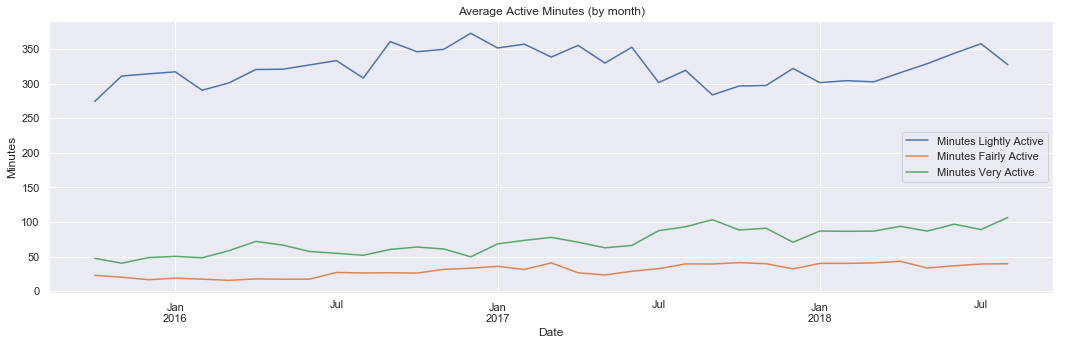

In [11]:
ACTIVITY_LEVELS = ['Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active']

#activities.groupby('Weekday').mean().plot(kind='bar', y=ACTIVITY_LEVELS, figsize=(15,5))
#activities.groupby(pd.Grouper(freq="M")).mean().plot(y=ACTIVITY_LEVELS)
activities.resample('M').mean().plot(y=ACTIVITY_LEVELS, figsize=(18,5))
plt.ylabel('Minutes')
plt.title('Average Active Minutes (by month)')
plt.show()

Fitbit's activity levels are determined by an individual's MET (metabolic equivalent) score, a score used to measure energy expenditure from physical activity. MET score of some physical activities are as follows:

| PHYSICAL ACTIVITY | MET |
| --- | --- |
| **Sedentary** | **< 1** |
| Sleeping | 0.9 |
| **Light intensity activities** | **1 < 3** |
| Watching TV | 1 |
| Desk work (e.g., writing, typing) | 1.5 |
| Strolling | 2.3 |
| Walking (2.5 mph) | 2.9 |
| **Moderate intensity activities** | **3-6** |
| Yoga | 3.2 |
| Walking (3 mph) | 3.3 |
| Bicycling (<10 mph) | 4 |
| Walking upstairs | 4.7 |
| **High intensity activities** | **6 <** |
| Jogging | 7 |
| Jump rope | 10 |
| Weight training | 10.9 |
| Basketball | 11.1 |

#### Light intensity (blue)
Average: 324.68
Standard deviation: 82.35

Overall the "Minutes Lightly Active" line is very jagged. This informs us that the amount of time xxx spends on activities that require minimal or no physical exertion is very unpredictable (unless looking at the graph in segments). FLUCTUATES WITH NO OBVIOUS DIRECTIONAL TREND

#### Moderate intensity (orange)
Average: 30.58
Standard deviation: 19.98

The "Minutes Fairly Active" line is relatively stable throughout. Looking at the whole graph, there seems to be a slight increase in amount of time spent on activities of moderate intensity. xxx allocates more time ...

#### High intensity (green)
Average: 73.24
Standard deviation: 48.18

xxx spends more than double the time doing vigorous activities than activities of moderate intensity. As seen on the graph, the line representing "Minutes Very Active" never meets the "Minutes Fairly Active" line.

From December 2016 to September 2017, there is an evident downward trend in "Minutes Lightly Active" while the opposite is observed for "Minutes Very Active". This points to high possibility that xxx was involved in more vigorous activities during that timeframe.

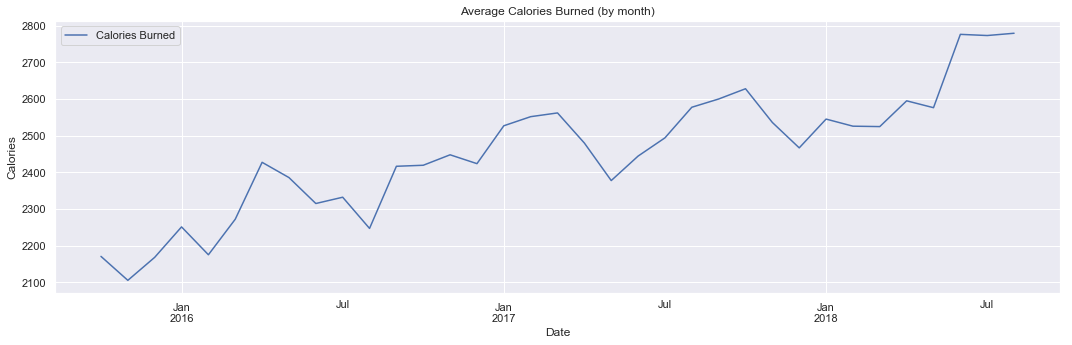

In [12]:
activities.resample('M').mean().plot(y='Calories Burned', figsize=(18,5))
plt.ylabel('Calories')
plt.title('Average Calories Burned (by month)')
plt.show()

Although jagged, there is an obvious upward trend in amount of calories xxx burned. Earlier we have observed an apparent increase in very active minutes over time, which supports the observation just made.

In [13]:
WEEK_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

activities_by_week = activities.groupby('Weekday').mean().reindex(WEEK_ORDER)
activities_by_week['Total Active Minutes'] = activities_by_week.iloc[:,6:8].sum(1)
activities_by_week#.iloc[:,5:8]

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Total Active Minutes
Weekday,,,,,,,,,,
Monday,2736.557047,19733.355705,7.950537,24.919463,452.833333,342.919463,38.221477,106.322148,1895.375839,144.543624
Tuesday,2535.684564,17657.510067,7.050671,22.080537,462.333333,382.140940,31.140940,66.281879,1687.993289,97.422819
Wednesday,2660.940000,19675.360000,7.931133,24.286667,616.666667,340.813333,35.686667,96.120000,1803.040000,131.806667
Thursday,2514.826667,17013.493333,6.824867,22.513333,519.500000,359.533333,31.766667,74.646667,1654.806667,106.413333
Friday,2286.906667,14649.326667,5.884600,21.720000,619.500000,350.273333,29.780000,41.400000,1390.660000,71.180000
Saturday,2445.181208,17916.261745,7.813691,25.288591,454.833333,259.234899,27.295302,84.281879,1511.697987,111.577181
Sunday,2035.604027,12160.369128,5.112081,20.174497,594.500000,236.765101,18.221477,36.805369,1018.234899,55.026846


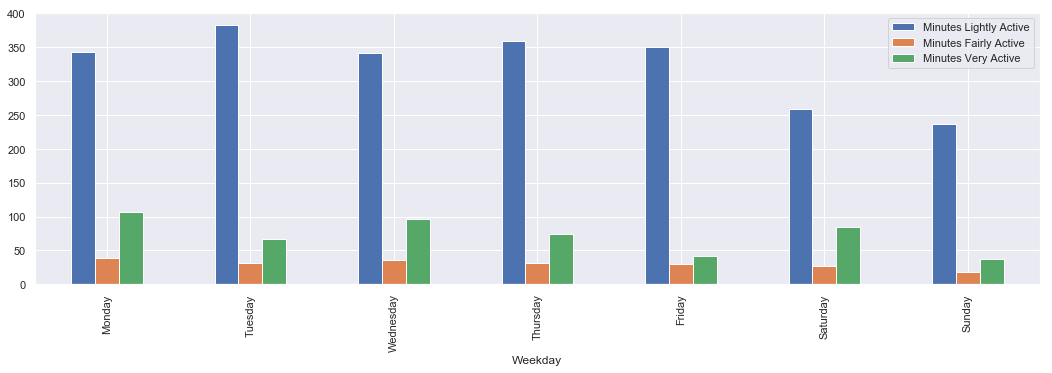

In [14]:
ax = activities_by_week.plot(kind='bar', y=ACTIVITY_LEVELS, figsize=(18,5))
plt.show()

In [36]:
# -- FOR SEPARATE VIEW --

#fig, activity_ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

#for i, level in enumerate(ACTIVITY_LEVELS):
 #   activities_by_week.plot(kind='bar', y=level, ax=activity_ax[i])
#plt.show()

If associating minutes lightly active as leisure and minutes fairly active as running errands, then we can see that 

For the most part, xxx is more active during the week with the exception of Saturday. According to the statistics displayed by day of the week, Saturday is one of her more active days ("Total Active Minutes" determined by summing the averages of "Minutes Fairly Active" and "Minutes Very Active").

In [37]:
# -- WORKS BUT IS IT NEEDED? --

#dims = (18,15)
#fig, ax = plt.subplots(1,3, sharey=True, figsize=dims)
#for i, level in enumerate(ACTIVITY_LEVELS):
 #   sns.boxplot(x='Weekday', y=level, data=activities, ax=ax[i])
    #sns.boxplot(x=activities_by_week.index, y=level, data=activities_by_week, ax=ax[i])

In [38]:
# -- WORKS, BUT CONTEMPLATING WHETHER OR NOT TO KEEP --

#dims = (18,15)
#fig, ax = plt.subplots(figsize=dims)
#activities_melted = activities.melt(id_vars='Weekday', value_vars=ACTIVITY_LEVELS, var_name='Activity Level', value_name='Minutes')
#lot = sns.boxplot(x='Weekday', y='Minutes', hue='Activity Level', data=activities_melted, ax=ax)
#plt.show()

In [15]:
for day, day_activity in activities.groupby('Weekday'):
    print(day)
    ICD.display(day_activity.describe())

Friday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,150.000000,150.000000,150.000000,150.000000,6.000000,150.000000,150.000000,150.00000,150.000000
mean,2286.906667,14649.326667,5.884600,21.720000,619.500000,350.273333,29.780000,41.40000,1390.660000
std,259.728313,3694.954845,1.765567,12.314187,237.445362,76.957663,19.394827,27.13402,314.407632
min,1696.000000,6720.000000,2.660000,6.000000,397.000000,162.000000,0.000000,0.00000,654.000000
25%,2113.500000,12376.250000,4.905000,14.000000,531.250000,300.000000,16.250000,26.00000,1163.500000
50%,2316.000000,15015.000000,5.950000,19.000000,536.500000,354.500000,26.000000,39.00000,1417.000000
75%,2423.750000,16397.500000,6.600000,25.000000,613.750000,407.000000,39.750000,53.00000,1578.500000
max,3745.000000,36241.000000,18.500000,80.000000,1078.000000,535.000000,111.000000,169.00000,2925.000000


Monday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,149.000000,149.000000,149.000000,149.000000,6.000000,149.000000,149.000000,149.000000,149.000000
mean,2736.557047,19733.355705,7.950537,24.919463,452.833333,342.919463,38.221477,106.322148,1895.375839
std,434.205353,5480.815226,2.223670,13.409616,196.127934,59.108640,22.822122,48.642417,516.719544
min,1478.000000,3577.000000,1.420000,5.000000,337.000000,101.000000,3.000000,3.000000,330.000000
25%,2438.000000,15715.000000,6.330000,17.000000,361.500000,313.000000,22.000000,73.000000,1545.000000
50%,2675.000000,18683.000000,7.780000,22.000000,367.000000,343.000000,35.000000,91.000000,1830.000000
75%,3073.000000,24171.000000,9.480000,27.000000,421.250000,383.000000,51.000000,145.000000,2288.000000
max,3678.000000,31174.000000,13.630000,85.000000,847.000000,468.000000,108.000000,258.000000,3007.000000


Saturday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,149.000000,149.000000,149.000000,149.000000,6.000000,149.000000,149.000000,149.000000,149.000000
mean,2445.181208,17916.261745,7.813691,25.288591,454.833333,259.234899,27.295302,84.281879,1511.697987
std,433.567711,7425.885880,3.833282,14.702590,166.768602,68.096453,15.324642,46.659503,484.858097
min,1539.000000,4888.000000,1.940000,1.000000,154.000000,57.000000,0.000000,3.000000,429.000000
25%,2168.000000,12901.000000,5.300000,15.000000,404.750000,215.000000,16.000000,53.000000,1208.000000
50%,2394.000000,16398.000000,6.660000,20.000000,530.000000,257.000000,24.000000,77.000000,1463.000000
75%,2657.000000,21698.000000,9.180000,31.000000,548.750000,312.000000,36.000000,105.000000,1780.000000
max,3728.000000,45651.000000,22.350000,74.000000,597.000000,415.000000,78.000000,240.000000,2830.000000


Sunday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,149.000000,149.000000,149.000000,149.000000,6.000000,149.000000,149.000000,149.000000,149.000000
mean,2035.604027,12160.369128,5.112081,20.174497,594.500000,236.765101,18.221477,36.805369,1018.234899
std,381.402583,5709.418076,2.669078,13.790288,161.256008,63.531796,15.266925,33.456644,378.098700
min,1446.000000,2802.000000,1.110000,3.000000,408.000000,104.000000,0.000000,0.000000,292.000000
25%,1758.000000,7546.000000,3.010000,11.000000,518.500000,195.000000,9.000000,9.000000,716.000000
50%,1991.000000,11243.000000,4.490000,16.000000,544.500000,233.000000,15.000000,29.000000,979.000000
75%,2261.000000,16025.000000,6.750000,24.000000,654.500000,278.000000,24.000000,55.000000,1318.000000
max,4479.000000,34728.000000,16.270000,86.000000,869.000000,453.000000,92.000000,172.000000,2565.000000


Thursday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,150.000000,150.000000,150.000000,150.000000,6.000000,150.000000,150.000000,150.000000,150.000000
mean,2514.826667,17013.493333,6.824867,22.513333,519.500000,359.533333,31.766667,74.646667,1654.806667
std,257.063039,3677.700264,1.575402,13.715096,93.485293,59.788292,17.184126,27.755436,314.011899
min,1659.000000,5423.000000,2.160000,4.000000,394.000000,175.000000,5.000000,2.000000,559.000000
25%,2358.000000,14554.250000,5.667500,15.000000,458.250000,325.250000,19.000000,55.250000,1459.000000
50%,2488.500000,16492.000000,6.650000,19.000000,523.500000,362.000000,29.000000,67.500000,1646.000000
75%,2641.000000,19549.750000,7.832500,24.750000,578.250000,401.750000,39.750000,92.500000,1823.000000
max,3237.000000,28255.000000,11.740000,111.000000,643.000000,499.000000,94.000000,157.000000,2520.000000


Tuesday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,149.000000,149.000000,149.000000,149.000000,6.000000,149.000000,149.000000,149.000000,149.000000
mean,2535.684564,17657.510067,7.050671,22.080537,462.333333,382.140940,31.140940,66.281879,1687.993289
std,278.273929,3867.392546,1.659461,12.073825,143.275492,67.843921,17.948507,25.631505,342.093307
min,1623.000000,5223.000000,2.090000,5.000000,263.000000,120.000000,3.000000,4.000000,529.000000
25%,2381.000000,15742.000000,6.040000,14.000000,390.500000,356.000000,18.000000,51.000000,1502.000000
50%,2564.000000,17631.000000,7.060000,19.000000,461.000000,390.000000,27.000000,64.000000,1729.000000
75%,2708.000000,20427.000000,8.380000,25.000000,518.750000,425.000000,42.000000,83.000000,1894.000000
max,3317.000000,25559.000000,10.170000,70.000000,684.000000,536.000000,107.000000,172.000000,2648.000000


Wednesday


,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,150.000000,150.000000,150.000000,150.000000,6.000000,150.000000,150.000000,150.000000,150.000000
mean,2660.940000,19675.360000,7.931133,24.286667,616.666667,340.813333,35.686667,96.120000,1803.040000
std,460.940944,5557.915139,2.325205,10.065115,434.608636,61.062339,22.994933,59.469232,549.395603
min,1697.000000,6381.000000,2.550000,7.000000,276.000000,0.000000,0.000000,0.000000,0.000000
25%,2306.250000,15231.500000,6.122500,18.000000,338.500000,307.000000,19.000000,43.250000,1411.000000
50%,2586.500000,19291.000000,7.785000,22.000000,476.500000,344.000000,31.500000,82.000000,1726.000000
75%,3003.750000,24034.500000,9.480000,28.750000,673.000000,377.750000,46.500000,139.500000,2225.000000
max,4341.000000,37581.000000,16.450000,62.000000,1440.000000,470.000000,114.000000,248.000000,3732.000000


## Sleep data
---

In [27]:
sleep

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Date,Weekday
0,2015-10-22 00:00:00,2015-10-22 05:07:00,292,15,1,307,2015-10-21,Wednesday
1,2015-10-22 21:29:00,2015-10-23 04:17:00,401,7,1,408,2015-10-22,Thursday
2,2015-10-23 21:47:00,2015-10-24 06:43:00,514,22,2,536,2015-10-23,Friday
3,2015-10-24 23:24:00,2015-10-25 07:16:00,459,13,1,472,2015-10-24,Saturday
4,2015-10-24 14:40:00,2015-10-24 16:05:00,80,5,0,85,2015-10-24,Saturday
5,2015-10-26 13:48:00,2015-10-26 15:54:00,116,10,1,126,2015-10-26,Monday
6,2015-10-26 21:51:00,2015-10-27 05:10:00,416,23,1,439,2015-10-26,Monday
7,2015-10-27 21:40:00,2015-10-28 05:32:00,449,23,1,472,2015-10-27,Tuesday
8,2015-10-29 22:53:00,2015-10-30 04:00:00,299,8,1,307,2015-10-29,Thursday
9,2015-10-29 00:09:00,2015-10-29 05:12:00,293,10,1,303,2015-10-28,Wednesday


In [16]:
to_date(sleep, ['Start Time', 'End Time'])
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 6 columns):
Start Time              1247 non-null datetime64[ns]
End Time                1247 non-null datetime64[ns]
Minutes Asleep          1247 non-null int64
Minutes Awake           1247 non-null int64
Number of Awakenings    1247 non-null int64
Time in Bed             1247 non-null int64
dtypes: datetime64[ns](2), int64(4)
memory usage: 58.5 KB


In [17]:
sleep.describe()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,1247.000000,1247.000000,1247.000000,1247.000000
mean,382.356055,29.630313,8.540497,412.478749
std,141.590898,21.100854,10.538765,153.540635
min,6.000000,0.000000,0.000000,60.000000
25%,367.000000,13.000000,1.000000,395.000000
50%,421.000000,25.000000,2.000000,454.000000
75%,466.000000,44.000000,18.000000,499.000000
max,704.000000,153.000000,44.000000,807.000000


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Weekday
Date,,,,,
2015-10-21,292,15,1,307,Wednesday
2015-10-22,401,7,1,408,Thursday
2015-10-23,514,22,2,536,Friday
2015-10-24,539,18,1,557,Saturday
2015-10-26,532,33,2,565,Monday
2015-10-27,449,23,1,472,Tuesday
2015-10-28,293,10,1,303,Wednesday
2015-10-29,299,8,1,307,Thursday
2015-10-30,520,32,1,552,Friday


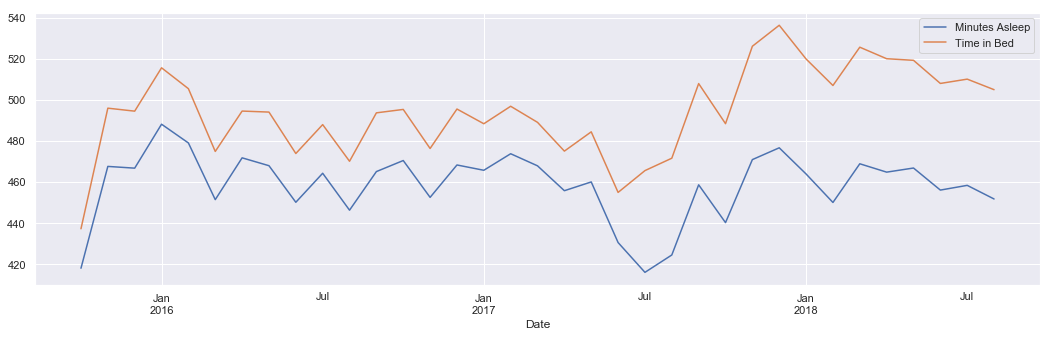

In [29]:
dates = []
for i in range(len(sleep['Start Time'])):
    date = sleep['Start Time'][i].date()
    time = sleep['Start Time'][i].time()
    if time > dt.time(4):
        dates.append(date)
    else:
        dates.append(date - timedelta(1))
sleep['Date'] = dates

daily_sleep = sleep.groupby('Date').sum()
daily_sleep.index = pd.to_datetime(daily_sleep.index)
add_weekday(daily_sleep)

daily_sleep.resample('M').mean().plot(y=['Minutes Asleep', 'Time in Bed'], figsize=(18,5))
daily_sleep

In [32]:
daily_sleep.groupby('Weekday').mean()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
Weekday,,,,
Friday,490.804054,39.270270,11.331081,531.331081
Monday,422.170068,33.517007,9.034014,455.959184
Saturday,532.557047,43.664430,12.744966,576.738255
Sunday,457.680272,35.836735,9.353741,494.292517
Thursday,460.228188,31.872483,10.630872,492.442953
Tuesday,424.959732,33.322148,9.053691,458.550336
Wednesday,426.691275,31.691275,9.651007,459.093960


In [30]:
for day, day_activity in daily_sleep.groupby('Weekday'):
    print(day)
    ICD.display(day_activity.describe())

Friday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,148.000000,148.000000,148.000000,148.000000
mean,490.804054,39.270270,11.331081,531.331081
std,71.075093,23.454282,11.906888,84.590923
min,329.000000,2.000000,0.000000,337.000000
25%,446.000000,22.000000,2.000000,479.000000
50%,485.000000,33.500000,3.000000,520.000000
75%,529.250000,53.000000,24.000000,576.250000
max,704.000000,118.000000,38.000000,807.000000


Monday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,147.000000,147.000000,147.000000,147.000000
mean,422.170068,33.517007,9.034014,455.959184
std,60.395089,18.636888,9.523162,64.491146
min,60.000000,1.000000,0.000000,66.000000
25%,391.000000,19.000000,2.000000,430.000000
50%,422.000000,29.000000,3.000000,459.000000
75%,448.000000,47.000000,17.500000,487.000000
max,581.000000,85.000000,33.000000,635.000000


Saturday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,149.000000,149.000000,149.000000,149.000000
mean,532.557047,43.664430,12.744966,576.738255
std,83.691872,24.513816,13.550783,95.637081
min,318.000000,4.000000,0.000000,357.000000
25%,475.000000,24.000000,2.000000,506.000000
50%,534.000000,39.000000,4.000000,581.000000
75%,585.000000,59.000000,26.000000,636.000000
max,797.000000,112.000000,46.000000,876.000000


Sunday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,147.000000,147.000000,147.000000,147.000000
mean,457.680272,35.836735,9.353741,494.292517
std,68.934850,20.235612,9.592236,70.896433
min,293.000000,6.000000,0.000000,307.000000
25%,409.000000,21.000000,2.000000,449.500000
50%,448.000000,30.000000,3.000000,483.000000
75%,501.000000,47.000000,18.500000,535.000000
max,662.000000,153.000000,37.000000,720.000000


Thursday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,149.000000,149.000000,149.000000,149.000000
mean,460.228188,31.872483,10.630872,492.442953
std,66.953405,19.709474,11.467551,75.737936
min,299.000000,2.000000,0.000000,307.000000
25%,415.000000,17.000000,1.000000,441.000000
50%,445.000000,27.000000,2.000000,477.000000
75%,490.000000,44.000000,22.000000,532.000000
max,709.000000,118.000000,38.000000,745.000000


Tuesday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,149.000000,149.000000,149.000000,149.000000
mean,424.959732,33.322148,9.053691,458.550336
std,60.249019,16.513004,9.315626,64.660907
min,88.000000,2.000000,0.000000,95.000000
25%,391.000000,21.000000,2.000000,422.000000
50%,426.000000,31.000000,3.000000,461.000000
75%,464.000000,44.000000,17.000000,493.000000
max,605.000000,75.000000,29.000000,625.000000


Wednesday


,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed
count,149.000000,149.000000,149.000000,149.000000
mean,426.691275,31.691275,9.651007,459.093960
std,57.979365,16.635561,10.071317,61.010006
min,290.000000,3.000000,0.000000,298.000000
25%,388.000000,19.000000,1.000000,423.000000
50%,428.000000,30.000000,3.000000,460.000000
75%,459.000000,44.000000,20.000000,493.000000
max,648.000000,76.000000,35.000000,705.000000


In [20]:
food

,Meal,Food,Calories,Date,Weekday
0,Breakfast,American Cheese,61,2015-11-09,Monday
1,Breakfast,"Bagel thins, Everything",110,2015-11-09,Monday
2,Breakfast,"Egg, Chicken, Fried",184,2015-11-09,Monday
3,Breakfast,"Ham Steak, Traditional",30,2015-11-09,Monday
4,Morning Snack,Dark Chocolate Dreams,170,2015-11-09,Monday
5,Morning Snack,Banana,90,2015-11-09,Monday
6,Morning Snack,"Rice Cakes, Salt Free",70,2015-11-09,Monday
7,Breakfast,"English Muffin, Original",129,2015-11-11,Wednesday
8,Breakfast,"Egg, Chicken, Fried",184,2015-11-11,Wednesday
9,Breakfast,Bacon Pre-Cooked (S),75,2015-11-11,Wednesday


In [36]:
food_group = food.groupby('Date')

# i is datetime.date
# x is dataframe (each day's food info)
#for i, x in food_group:
 #   print(i)
  #  print(x)

food_group

In [41]:
new_food

,Meal,Food,Calories,Weekday
Date,,,,
2015-11-09,Breakfast,American Cheese,61,Monday
2015-11-09,Breakfast,"Bagel thins, Everything",110,Monday
2015-11-09,Breakfast,"Egg, Chicken, Fried",184,Monday
2015-11-09,Breakfast,"Ham Steak, Traditional",30,Monday
2015-11-09,Morning Snack,Dark Chocolate Dreams,170,Monday
2015-11-09,Morning Snack,Banana,90,Monday
2015-11-09,Morning Snack,"Rice Cakes, Salt Free",70,Monday
2015-11-11,Breakfast,"English Muffin, Original",129,Wednesday
2015-11-11,Breakfast,"Egg, Chicken, Fried",184,Wednesday


In [1]:
#food.groupby(pd.TimeGrouper('D'))
#for food_type, info in food.groupby('Food'):
 #   print(food_type)
  #  print(info['Date'])
food.groupby('Food').count()

#food_dict = food.groupby('Food').groups
#for key, value in food_dict.items():
 #   print(type(value))
    
new_food = food.set_index('Date')#.T.to_dict('list')
new_food.to_dict('records')
food.groupby('Date').apply(lambda x: x.to_dict(orient='list')).to_dict()

NameError: name 'food' is not defined

In [23]:
#macros.columns = ['Calories (g)', 'Carbs (g)', 'Fat (g)', 'Fiber (g)', 'Protein (g)', 'Sodium (mg)', 'Water (fl oz)', 'Weekday']

to_num(macros, ['Calories', 'Carbs', 'Fat', 'Fiber', 'Protein', 'Sodium', 'Water'])

In [24]:
macros

Food,Calories,Carbs,Fat,Fiber,Protein,Sodium,Water,Weekday
Date,,,,,,,,
2015-11-09,715,72,34,8,35,943,0,Monday
2015-11-11,797,74,39,4,37,1064,0,Wednesday
2015-11-12,1049,108,45,11,53,1216,0,Thursday
2015-11-30,90,20,0,1,1,2,0,Monday
2015-12-02,240,29,6,3,17,152,0,Wednesday
2015-12-09,860,101,35,8,37,1105,0,Wednesday
2015-12-10,1054,135,40,26,58,1210,0,Thursday
2015-12-11,1157,155,35,23,68,679,0,Friday
2015-12-15,1162,142,44,13,57,1402,0,Tuesday


In [25]:
macros.describe()

Food,Calories,Carbs,Fat,Fiber,Protein,Sodium,Water
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,1074.486381,126.416342,40.299611,15.836576,55.431907,1361.291829,8.264591
std,628.853950,78.375310,26.870198,10.934667,35.623194,1048.144818,22.149175
min,60.000000,9.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,633.000000,72.000000,22.000000,8.000000,30.000000,668.000000,0.000000
50%,898.000000,102.000000,34.000000,13.000000,42.000000,1101.000000,0.000000
75%,1375.000000,167.000000,49.000000,21.000000,75.000000,1559.000000,0.000000
max,2949.000000,389.000000,121.000000,63.000000,172.000000,5683.000000,106.000000


In [128]:
macros.index = pd.to_datetime(macros.index)
macros.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2015-11-09 to 2018-08-29
Data columns (total 8 columns):
Calories    243 non-null int64
Carbs       243 non-null object
Fat         243 non-null object
Fiber       243 non-null object
Protein     243 non-null object
Sodium      243 non-null object
Water       243 non-null object
Weekday     243 non-null object
dtypes: int64(1), object(7)
memory usage: 17.1+ KB


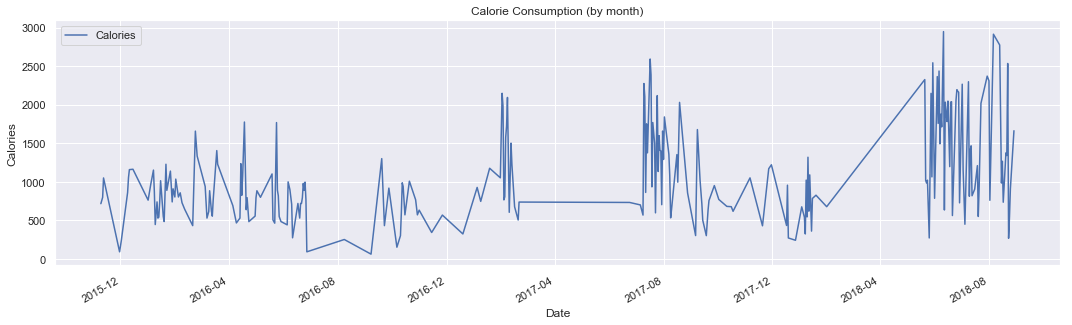

In [134]:
#macros.resample('D').mean().plot(y='Calories', figsize=(18,5))
macros.plot(y='Calories', figsize=(18,5))
plt.ylabel('Calories')
plt.title('Calorie Consumption (by month)')
plt.show()